In [1]:
import torch # version 2.1.2
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import YoloV1
from dataset import VOCDataset
from loss import YoloLoss
from utils import *

seed = 3301 #pseudorandom seed, gets the same dataset loading
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

torch.Size([2, 1470])
Using device cuda


In [2]:
# Hyperparameters for our model
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
WEIGHT_DECAY = 0    # no regularization in order for fast training
EPOCHS = 100

# Other variables for training
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

In [3]:
# trains through the entire dataset once
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE) 
        # x has shape torch.Size([batchSize, 3, 448, 448])
        # y has shape torch.Size([batchSize, 7, 7, 30])
        
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Average loss per image for this epoch was: {sum(mean_loss)/len(mean_loss)}")

In [4]:
model = YoloV1(split_size = 7, num_boxes = 2, num_classes = 20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

transform = transforms.Compose([
    transforms.Resize((448, 448)), 
    transforms.ToTensor()
    ])

train_dataset = VOCDataset(
    "data/8examples.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

test_dataset = VOCDataset(
    "data/test.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       #We have 8 examples, so false, but true if more than BATCH_SIZE
)

model.train()
for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    # pred_boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    # target_boxes = ^
    # note: the length of these lists >= numDatapoints

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")
    # if mean_avg_prec > 0.9:
    #     checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer": optimizer.state_dict(),
    #     }
    #     save_checkpoint(checkpoint, filename= LOAD_MODEL_FILE)
    #     import time
    #     time.sleep(10)
    train_fn(train_loader, model, optimizer, loss_fn)

Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.05it/s, loss=698]

Average loss per image for this epoch was: 697.8616333007812


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=235]

Average loss per image for this epoch was: 235.31231689453125


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, loss=156]

Average loss per image for this epoch was: 155.8233184814453


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.83it/s, loss=111]

Average loss per image for this epoch was: 111.17414855957031


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.91it/s, loss=85.5]

Average loss per image for this epoch was: 85.52538299560547


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, loss=67.4]

Average loss per image for this epoch was: 67.37664031982422


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, loss=54.2]

Average loss per image for this epoch was: 54.247764587402344


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.90it/s, loss=44.1]

Average loss per image for this epoch was: 44.12397003173828


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.91it/s, loss=36]

Average loss per image for this epoch was: 35.96219253540039


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.88it/s, loss=29.6]

Average loss per image for this epoch was: 29.597240447998047


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.89it/s, loss=24.5]

Average loss per image for this epoch was: 24.512691497802734


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss=20.3]

Average loss per image for this epoch was: 20.30430793762207


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.87it/s, loss=17.1]

Average loss per image for this epoch was: 17.05284309387207


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.87it/s, loss=14.3]

Average loss per image for this epoch was: 14.31627082824707


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.88it/s, loss=12]

Average loss per image for this epoch was: 12.039124488830566


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, loss=10.2]

Average loss per image for this epoch was: 10.21681022644043


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, loss=8.61]

Average loss per image for this epoch was: 8.61072063446045


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, loss=7.31]

Average loss per image for this epoch was: 7.311192512512207


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.82it/s, loss=6.14]

Average loss per image for this epoch was: 6.138264179229736


Train mAP: 0.0


100%|██████████| 1/1 [00:00<00:00,  1.83it/s, loss=5.07]

Average loss per image for this epoch was: 5.074731349945068


Train mAP: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
a = [[9.0, -0.00447857053950429, -0.0040930090472102165, 0.004413866437971592, -0.00012887165939901024, -0.0006599870976060629], [12.0, 0.03512659668922424, 0.14250969886779785, 0.006407114211469889, 0.0019285362213850021, 0.0011535281082615256], [7.0, 0.03828109800815582, 0.27962276339530945, -0.004415878094732761, 9.495063568465412e-05, -0.0048441472463309765], [3.0, 0.007269570138305426, 0.4235725700855255, -0.0008942492422647774, -0.00111678009852767, -0.0029086472932249308], [0.0, 0.019474778324365616, 0.5706158876419067, 0.004861082881689072, -0.003029408399015665, -0.005417516455054283], [19.0, 0.008278743363916874, 0.7139575481414795, -0.0035446765832602978, -0.0016703004948794842, -0.0046268850564956665], [0.0, 0.013240250758826733, 0.8557520508766174, 0.0041033318266272545, -0.006261428818106651, 0.00046632852172479033], [9.0, -0.02746202051639557, -0.0012930312659591436, 0.1464831829071045, -0.0046988604590296745, -0.005762253422290087], [14.0, 0.027727864682674408, 0.1482362151145935, 0.1384383589029312, 0.0007288562483154237, -0.0048144483007490635], [9.0, 0.01739213615655899, 0.28500014543533325, 0.14038759469985962, -0.0009021860314533114, 0.004685837775468826], [12.0, 0.028325749561190605, 0.42235592007637024, 0.13832810521125793, 0.0033006430603563786, -0.0003762780106626451], [10.0, 0.03068079613149166, 0.5693187713623047, 0.13697560131549835, 0.003927138168364763, -0.0062613519839942455], [11.0, -0.018516581505537033, 0.7117587924003601, 0.13701260089874268, 0.0058852494694292545, -0.003978534135967493], [9.0, 0.03275293856859207, 0.8511915802955627, 0.14673994481563568, 0.00141690403688699, -0.0013700032141059637], [8.0, 0.044485174119472504, -0.006214263383299112, 0.287583589553833, -0.0023664289619773626, -0.006351737305521965], [13.0, -0.0020367680117487907, 0.14684441685676575, 0.2899317145347595, 0.0036511803045868874, -0.005165999289602041], [10.0, -0.015151835978031158, 0.28609901666641235, 0.2818388342857361, -0.00022828885994385928, -0.000629449903499335], [6.0, 0.03295289725065231, 0.42361921072006226, 0.2838820517063141, -0.0033466541208326817, -0.0037178138736635447], [17.0, -0.01464749127626419, 0.5667695999145508, 0.2848909795284271, 0.006017185281962156, -0.0027412273921072483], [0.0, 0.02766827493906021, 0.7098246812820435, 0.2829887270927429, 0.001128339790739119, -0.004450147971510887], [2.0, 0.04383352771401405, 0.8560065031051636, 0.2831105589866638, 0.003273242386057973, 0.0010589134180918336], [13.0, 0.0032594148069620132, 0.004003729205578566, 0.42449861764907837, -0.0023702660109847784, -0.00602455111220479], [0.0, 0.03677961602807045, 0.14714664220809937, 0.42713239789009094, -0.002595024649053812, 0.0034236356150358915], [1.0, 0.039829935878515244, 0.28581079840660095, 0.4339667558670044, 0.0022707004100084305, -0.00429332023486495], [19.0, 0.04073590785264969, 0.4312833249568939, 0.42359915375709534, -0.005220831837505102, -0.0034240903332829475], [8.0, 0.005105148069560528, 0.567769467830658, 0.4311327338218689, -0.0008264744537882507, 0.0012284001568332314], [13.0, 0.03278679773211479, 0.7103895545005798, 0.4251438081264496, -0.0018110987730324268, 0.005804208107292652], [0.0, 0.022045638412237167, 0.854602038860321, 0.42930537462234497, 0.004890292417258024, -0.0039006664883345366], [0.0, 0.0016218360979110003, -0.0027484723832458258, 0.5694088339805603, 0.0005087749450467527, 0.0025374216493219137], [0.0, 0.007005299907177687, 0.14214900135993958, 0.5762407183647156, -0.0032153872307389975, -0.006412614602595568], [11.0, 0.035038892179727554, 0.28580114245414734, 0.5667290091514587, 0.002686444204300642, -0.003214061725884676], [18.0, 0.010495154187083244, 0.42394211888313293, 0.5761986970901489, -0.0046750339679419994, 0.0035089161247015], [5.0, 0.034586433321237564, 0.5775536894798279, 0.5705042481422424, 0.0045342594385147095, -0.0009398013935424387], [4.0, 0.0318327434360981, 0.713551938533783, 0.569297730922699, -0.0027056580875068903, -0.0029129297472536564], [6.0, -0.035839155316352844, 0.8567549586296082, 0.5657038688659668, 0.0006908481591381133, 0.0022081094793975353], [12.0, 0.03298424556851387, 0.0004143828118685633, 0.7129310369491577, -0.0003295346687082201, -0.0016457393066957593], [9.0, 0.0007408689125441015, 0.14246833324432373, 0.7084318995475769, -0.003874242538586259, -0.005173621233552694], [15.0, -0.027241036295890808, 0.2813534438610077, 0.7113856077194214, 0.004048868548125029, -0.0034770213533192873], [11.0, 0.0305313840508461, 0.426641047000885, 0.7196441292762756, -0.0015706332633271813, -1.3985717487230431e-05], [5.0, -0.01464149821549654, 0.5698648691177368, 0.7163196206092834, -0.0016335832187905908, -0.001573130371980369], [17.0, 0.03782704845070839, 0.7145930528640747, 0.7165780663490295, 0.004270481877028942, -0.002551693469285965], [19.0, 0.03773760050535202, 0.8580325245857239, 0.7182281613349915, 0.0003410981153137982, -0.005824158899486065], [19.0, 0.025862086564302444, 0.005973521154373884, 0.8545119762420654, 0.004715138580650091, -0.0005188951618038118], [10.0, 0.02633032575249672, 0.14085941016674042, 0.8601422309875488, -0.001850909786298871, -0.0049986266531050205], [1.0, 0.0401742197573185, 0.2823815941810608, 0.8623781800270081, 0.0024494659155607224, 0.0052193268202245235], [1.0, 0.04251426085829735, 0.428101122379303, 0.8512580394744873, 0.0009135758155025542, 0.00022030618856661022], [3.0, 0.030239352956414223, 0.57508385181427, 0.8616212606430054, 0.0045610577799379826, 0.003697192994877696], [19.0, -0.01671406254172325, 0.7139023542404175, 0.8525503277778625, 0.006308289244771004, -0.0017776752356439829], [18.0, -0.013187131844460964, 0.8528192043304443, 0.8525683879852295, 0.0023901734966784716, 0.002360858954489231]]
print(len(a))

49


In [6]:
p = torch.randn([2, 3, 5])
print(p)

# Get the maximum along dim = 0 (axis = 0)
max_elements, max_idxs = torch.max(p, dim=2)
print()
print(max_elements)
print()
print(max_idxs)

tensor([[[-1.1953,  0.5421, -1.0104, -1.2957,  0.1309],
         [ 0.3122, -0.0755,  0.9681, -1.5246,  1.0788],
         [-0.6153, -1.4696,  1.5714, -0.6075,  1.7324]],

        [[-0.9203, -2.4224,  0.3911, -1.4789,  1.9900],
         [-1.0347, -0.1311,  0.7434, -1.1323, -0.4631],
         [ 0.4536,  0.7088,  0.4362,  0.1151, -0.2409]]])

tensor([[0.5421, 1.0788, 1.7324],
        [1.9900, 0.7434, 0.7088]])

tensor([[1, 4, 4],
        [4, 2, 1]])


In [7]:
for x, y in train_loader:
    # print(x.shape) returns torch.Size([batchSize, 3, 448, 448])
    # print(y.shape) returns torch.Size([batchSize, 7, 7, 30])
    pass

In [8]:
train_dataset = VOCDataset(
    "data/8examples.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = False       #We have 8 examples, so false, but true if more than BATCH_SIZE
)

pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)

import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import *

print('pred boxes')
for row in pred_boxes:
    print(row)

print()
print()
print('target boxes')
for row in target_boxes:
    print(row)

pred boxes
[0, 6.0, 0.9921081066131592, 0.6447176337242126, 0.5663289427757263, 0.7134292721748352, 0.8359788656234741]
[1, 14.0, 1.000640869140625, 0.6115490794181824, 0.7085031867027283, 0.08396439999341965, 0.34538716077804565]
[1, 14.0, 0.9984416365623474, 0.5547958016395569, 0.7027007937431335, 0.0774746686220169, 0.34810492396354675]
[1, 12.0, 0.9967237710952759, 0.3391517996788025, 0.6684219241142273, 0.4004324972629547, 0.4193528890609741]
[1, 14.0, 0.995032787322998, 0.3788360357284546, 0.5663706660270691, 0.1577899158000946, 0.379567950963974]
[2, 1.0, 0.9977700710296631, 0.5981547236442566, 0.5412594079971313, 0.6334388852119446, 0.7979870438575745]
[3, 7.0, 0.9990514516830444, 0.2762495279312134, 0.49569860100746155, 0.5081291794776917, 0.3885619044303894]
[3, 7.0, 0.9959426522254944, 0.7143478989601135, 0.45768409967422485, 0.5018686056137085, 0.44621142745018005]
[4, 6.0, 0.9922118186950684, 0.540418803691864, 0.56657874584198, 0.8978562951087952, 0.5339452028274536]
[5, 

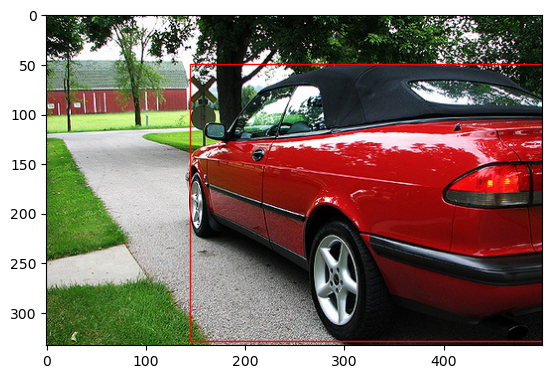

In [9]:
import cv2
plot_image(cv2.imread("data/images/000007.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 0])

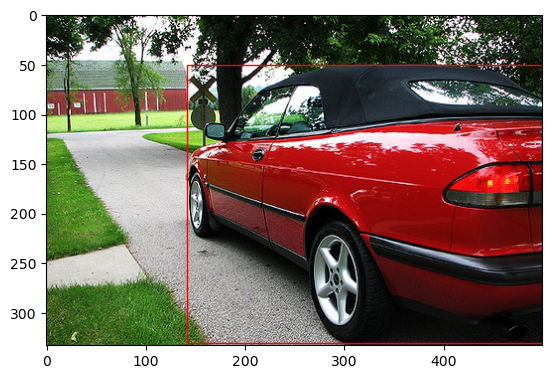

In [10]:
import cv2
plot_image(cv2.imread("data/images/000007.jpg")[...,::-1], [box for box in target_boxes if box[0] == 0])

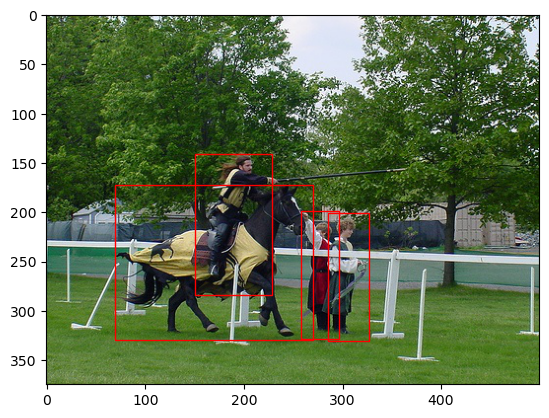

In [11]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 1])

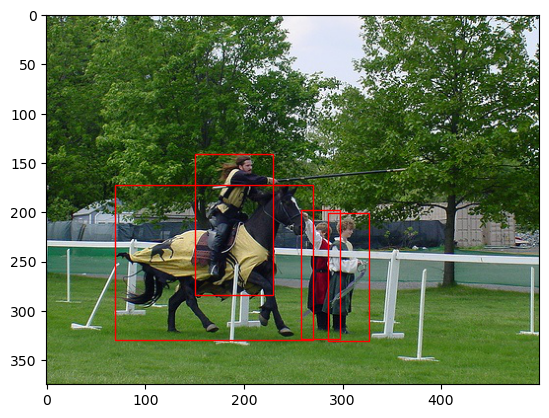

[[1, 14.0, 1.0, 0.3790000379085541, 0.5666667222976685, 0.15800002217292786, 0.3813333213329315], [1, 12.0, 1.0, 0.33900001645088196, 0.6693333387374878, 0.4020000398159027, 0.421333372592926], [1, 14.0, 1.0, 0.5550000071525574, 0.7026666402816772, 0.07800000160932541, 0.34933337569236755], [1, 14.0, 1.0, 0.6119999885559082, 0.7093333601951599, 0.08400000631809235, 0.34666669368743896]]


In [16]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in target_boxes if box[0] == 1])
print([box for box in target_boxes if box[0] == 1])

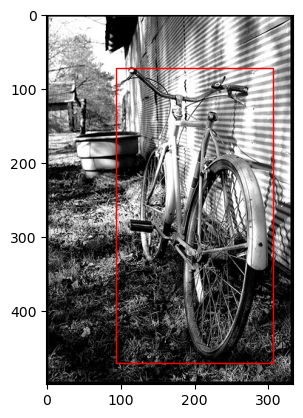

In [12]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 2])

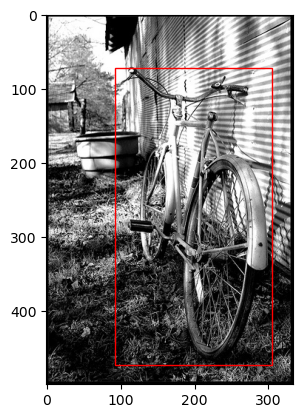

In [29]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in target_boxes if box[0] == 2])